In [85]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

In [19]:
# actual conversions from UI.
# represent daily conversion in 3 channels on a single tag
data = [ [373, 10], [155, 6],[191, 4] ]
df = pd.DataFrame(data, columns=['n', 'y'])
coords = dict(channels=df.index)
df['i'] = df.index

In [124]:
with pm.Model(coords=coords) as model:
    z0 = pm.Normal('z0',0,1)
    z = pm.Normal('z',z0,1, dims='channels')
    p = pm.Deterministic('p', pm.math.sigmoid(z +  np.log(1/100)))
    y = pm.Binomial('y', p=p, n=df.n.values, observed=df.y.values)

In [125]:
# check if model produce some reasonable data without seeing data.
# aka forward probability
with model:
    y_ppc = pm.sample_prior_predictive()

In [126]:
# expected to be greater than 0.05 and below 0.95, should be ~ 0.5
def T_samples_less_then_observed(i, y):
    return np.mean(y_ppc['y'][:,i] <= y)

# expected to be above 0.99
def T_samples_with_unrealistic_conversion(i, n):
    return np.mean(y_ppc['y'][:,i] <= n * 0.2)

In [127]:
df.apply(lambda x: T_samples_less_then_observed(x.i, x.y), axis=1)

0    0.770
1    0.848
2    0.718
dtype: float64

In [128]:
df.apply(lambda x: T_samples_with_unrealistic_conversion(x.i, x.n), axis=1)

0    0.988
1    0.988
2    0.988
dtype: float64

In [129]:
# inference aka backward probability
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, z0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<AxesSubplot:title={'center':'z0'}>,
        <AxesSubplot:title={'center':'z0'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

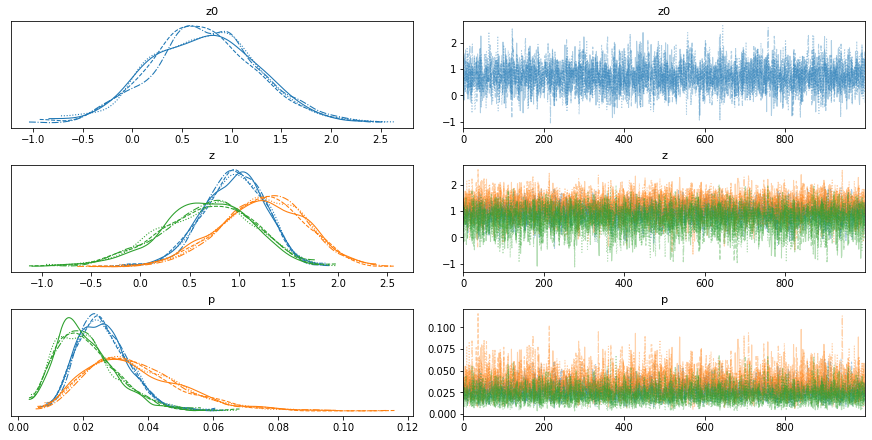

In [130]:
az.plot_trace(trace)

In [131]:
# posterior predictive aka forward probability
with model:
    y_ppc = pm.sample_posterior_predictive(trace=trace)

In [134]:
df.apply(lambda x: T_samples_less_then_observed(x.i, x.y), axis=1)

0    0.60475
1    0.66350
2    0.64050
dtype: float64

In [135]:
df.apply(lambda x: T_samples_with_unrealistic_conversion(x.i, x.n), axis=1)

0    1.0
1    1.0
2    1.0
dtype: float64